/var/folders/g6/pn8l9d616gl87vwf5lxtp0nr0000gn/T/ipykernel_81215/2310766172.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), palette="Set2")


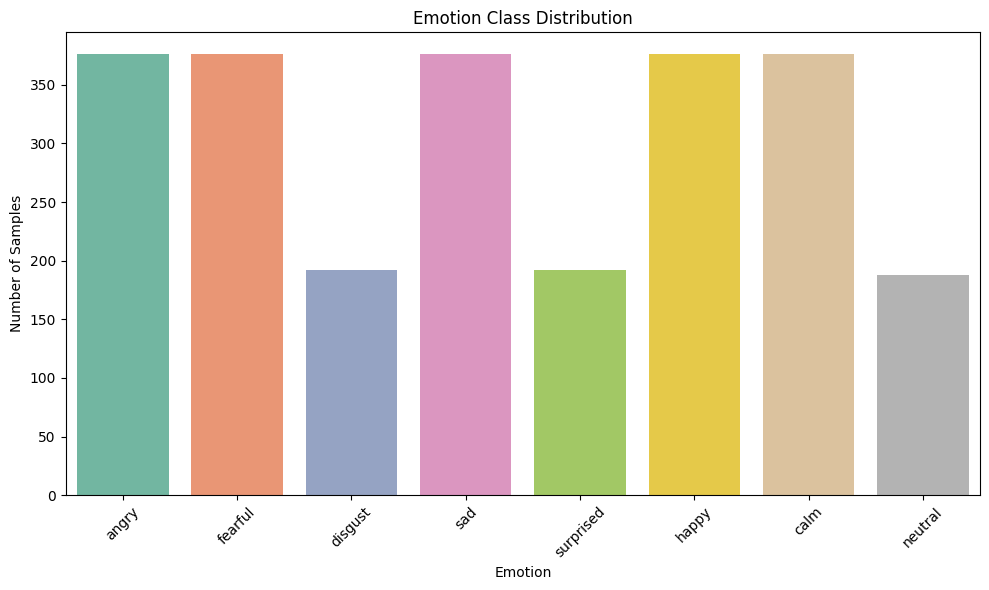

In [19]:
import os
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

def extract_features(file_path, sr=22050, duration=3, n_mfcc=13):
    try:
        audio, _ = librosa.load(file_path, sr=sr, mono=True, duration=duration)
        
        # === Core features ===
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_combined = np.vstack([mfcc, delta, delta2])  # shape: (39, T)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        rms = librosa.feature.rms(y=audio)

        # === Aggregate with mean ===
        features = np.hstack([
            np.mean(mfcc_combined, axis=1),
            np.mean(chroma, axis=1),
            np.mean(contrast, axis=1),
            np.mean(zcr),
            np.mean(rms)
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# === Load Dataset ===
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_emotion_from_filename(filename):
    try:
        emotion_code = filename.split("-")[2]
        return emotion_map.get(emotion_code, "unknown")
    except:
        return "unknown"

def load_dataset(folder_paths):
    X, Y = [], []
    for folder_path in folder_paths:
        for actor_folder in os.listdir(folder_path):
            actor_path = os.path.join(folder_path, actor_folder)
            if not os.path.isdir(actor_path):
                continue
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)
                    emotion_label = extract_emotion_from_filename(file)
                    if emotion_label == "unknown":
                        continue
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        Y.append(emotion_label)
    return np.array(X), np.array(Y)





# === Example usage ===
folder_path=[
    '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24',
     '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24'
]
X, Y = load_dataset(folder_path)


import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count instances of each emotion class
emotion_counts = Counter(Y)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), palette="Set2")

plt.title("Emotion Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





from sklearn.preprocessing import LabelEncoder




In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# === Split before SMOTE ===
x_train, x_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded)

# === Apply SMOTE on train set ===
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# === Confirm new distribution ===
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({np.int64(3): 301, np.int64(0): 301, np.int64(1): 301, np.int64(6): 301, np.int64(4): 301, np.int64(7): 153, np.int64(2): 153, np.int64(5): 150})
After SMOTE: Counter({np.int64(3): 301, np.int64(5): 301, np.int64(0): 301, np.int64(1): 301, np.int64(7): 301, np.int64(6): 301, np.int64(2): 301, np.int64(4): 301})


In [21]:
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)
label_names = encoder.classes_


# === Train Test Split ===

x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2,random_state=42,stratify=Y_encoded)


# === Random Forest ===
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(x_train, y_train)

# === Evaluation ===
y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[45  2  5 11  6  0  1  5]
 [ 0 62  0  1  2  2  8  0]
 [ 1  4 17  4  2  1  8  2]
 [10  4  3 27  7  0 17  7]
 [ 4  5  2  6 48  1  6  3]
 [ 0  5  1  0  4 23  5  0]
 [ 2 12  2 11  5  1 42  0]
 [ 0  1  2  2  2  1  2 29]]
              precision    recall  f1-score   support

           0       0.73      0.60      0.66        75
           1       0.65      0.83      0.73        75
           2       0.53      0.44      0.48        39
           3       0.44      0.36      0.39        75
           4       0.63      0.64      0.64        75
           5       0.79      0.61      0.69        38
           6       0.47      0.56      0.51        75
           7       0.63      0.74      0.68        39

    accuracy                           0.60       491
   macro avg       0.61      0.60      0.60       491
weighted avg       0.60      0.60      0.59       491



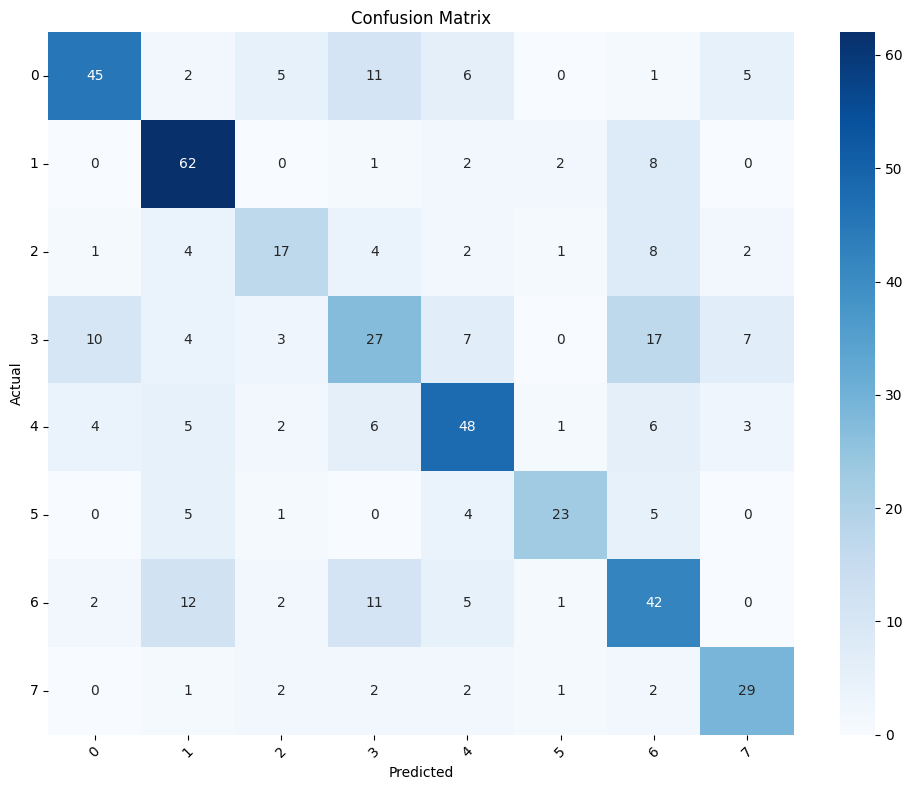

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
